In [27]:
import tensorflow as tf

# 探测是否有GPU设备
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用

    #     指定哪些PhysicalDevice 对象对运行时可见。
    #     TensorFlow 只会在可见的物理设备上分配内存和放置操作，否则不会在它们上创建 LogicalDevice。
    #     默认情况下，所有发现的设备都标记为可见
    tf.config.set_visible_devices([gpus[0]], "GPU")

# 打印显卡信息，确认GPU可用
print(gpus)

RuntimeError: Physical devices cannot be modified after being initialized

In [28]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os, math
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [3]:
data = pd.read_csv('./datasets/data.csv')  # 读取股票文件

# 粗略显示文件信息
data

,Unnamed: 0,date,open,close,high,low,volume,code
0,74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
1,75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
2,76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
3,77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
4,78,2010-04-30,83.871,82.340,83.871,81.523,85566.70,600519
...,...,...,...,...,...,...,...,...
2421,2495,2020-04-20,1221.000,1227.300,1231.500,1216.800,24239.00,600519
2422,2496,2020-04-21,1221.020,1200.000,1223.990,1193.000,29224.00,600519
2423,2497,2020-04-22,1206.000,1244.500,1249.500,1202.220,44035.00,600519
2424,2498,2020-04-23,1250.000,1252.260,1265.680,1247.770,26899.00,600519


In [4]:
"""
前(2426-300=2126)天的开盘价作为训练集
后300天的开盘价作为测试集

表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价(open列)
"""
training_set = data.iloc[0:2426 - 300, 2:3].values
test_set = data.iloc[2426 - 300:, 2:3].values

In [5]:
# https://blog.csdn.net/weixin_43135178/article/details/124320736
# Pandas中loc和iloc函数（提取某几列或者行的数据）

In [6]:
training_set

array([[ 88.702],
       [ 87.355],
       [ 84.235],
       ...,
       [670.3  ],
       [675.88 ],
       [684.   ]])

In [7]:
# https://blog.csdn.net/Fwuyi/article/details/123137074
# MinMaxScaler(feature_range=(0,1))（sklearn库）

sc = MinMaxScaler(feature_range=(0, 1))
training_set = sc.fit_transform(training_set)
test_set = sc.transform(test_set)

In [8]:
training_set

array([[0.011711  ],
       [0.00980951],
       [0.00540518],
       ...,
       [0.83272021],
       [0.84059718],
       [0.85205973]])

In [9]:
x_train = []
y_train = []

x_test = []
y_test = []
"""
使用前60天的开盘价作为输入特征x_train
    第61天的开盘价作为输入标签y_train
    
for循环共构建2426-300-60=2066组训练数据。
       共构建300-60=260组测试数据
"""
for i in range(60, len(training_set)):
    x_train.append(training_set[i - 60:i, 0])
    y_train.append(training_set[i, 0])

for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])

# 对训练集进行打乱
# 要对数据集乱序，输入特征是第1组数据，标签是第2组数据，要对输入特征和标签都做乱序，为了一一对应，就需要随机种子确定
# https://blog.csdn.net/qq_36201400/article/details/108512368
# tf.random.set_seed用法

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

In [10]:
"""
将训练数据（list）调整为数组（array）

最终目的：
x_train:(2066, 60, 1)
y_train:(2066,)
x_test :(240, 60, 1)
y_test :(240,)
"""

x_train, y_train = np.array(x_train), np.array(y_train) # x_train形状为：(2066, 60, 1)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

In [11]:
x_train.shape

(2066, 60)

In [12]:
x_test.shape

(240, 60)

In [45]:
"""
输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
"""
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

In [46]:
x_train.shape

(2066, 60, 1)

In [47]:
x_test.shape

(240, 60, 1)

In [113]:
model = tf.keras.Sequential([
    SimpleRNN(110, return_sequences=True), #布尔值。是返回输出序列中的最后一个输出，还是全部序列。
    Dropout(0.2),                         #防止过拟合
    SimpleRNN(110),
    Dropout(0.1),
    Dense(1)
])

# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差

In [115]:
history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    validation_freq=1)  #测试的epoch间隔数

model.summary()

Epoch 1/10
33/33 [==============================] - 8s 213ms/step - loss: 0.0865 - val_loss: 0.0220 ETA: 1s - los
Epoch 2/10
33/33 [==============================] - 7s 206ms/step - loss: 0.0155 - val_loss: 0.0440
Epoch 3/10
33/33 [==============================] - 7s 208ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 4/10
33/33 [==============================] - 7s 215ms/step - loss: 0.0060 - val_loss: 0.0145
Epoch 5/10
33/33 [==============================] - 7s 209ms/step - loss: 0.0047 - val_loss: 0.0200
Epoch 6/10
33/33 [==============================] - 7s 201ms/step - loss: 0.0042 - val_loss: 0.0185
Epoch 7/10
33/33 [==============================] - 7s 204ms/step - loss: 0.0036 - val_loss: 0.0238
Epoch 8/10
33/33 [==============================] - 7s 202ms/step - loss: 0.0036 - val_loss: 0.0146
Epoch 9/10
33/33 [==============================] - 7s 199ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 10/10
33/33 [==============================] - 7s 202ms/step - loss: 0.0029 - va

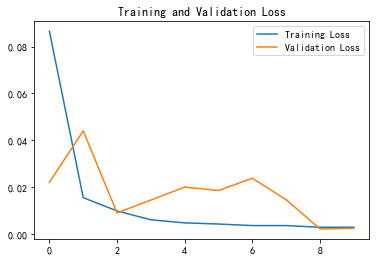

In [116]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('pic1.jpg', dpi=600) #指定分辨率保存
plt.show()

In [117]:
predicted_stock_price.shape

(240, 1)

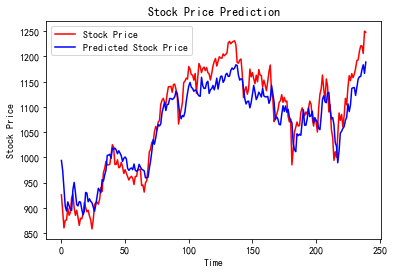

In [118]:
predicted_stock_price = model.predict(x_test)  # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(
    predicted_stock_price)  # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(
    test_set[60:])  # 对真实数据还原---从（0，1）反归一化到原始范围

# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('pic2.jpg', dpi=600) #指定分辨率保存
plt.show()

In [119]:
"""
MSE  ：均方误差    ----->  预测值减真实值求平方后求均值
RMSE ：均方根误差  ----->  对均方误差开方
MAE  ：平均绝对误差----->  预测值减真实值求绝对值后求均值
R2   ：决定系数，可以简单理解为反映模型拟合优度的重要的统计量

详细介绍可以参考文章：https://blog.csdn.net/qq_38251616/article/details/107997435
"""
MSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2 = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

均方误差: 1195.69426
均方根误差: 34.57881
平均绝对误差: 28.94272
R2: 0.81633


In [120]:
# 保存模型
# model.save('model_81.6%')

INFO:tensorflow:Assets written to: model_81.6%\assets


# tensorboard可视化(2.x版本)

## tensorboard小例子

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]], "GPU")

In [29]:
import os, math
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

data = pd.read_csv('./datasets/data.csv')  # 读取股票文件
training_set = data.iloc[0:2426 - 300, 2:3].values
test_set = data.iloc[2426 - 300:, 2:3].values

sc = MinMaxScaler(feature_range=(0, 1))
training_set = sc.fit_transform(training_set)
test_set = sc.transform(test_set)

x_train = []
y_train = []

x_test = []
y_test = []
"""
使用前60天的开盘价作为输入特征x_train
    第61天的开盘价作为输入标签y_train
    
for循环共构建2426-300-60=2066组训练数据。
       共构建300-60=260组测试数据
"""
for i in range(60, len(training_set)):
    x_train.append(training_set[i - 60:i, 0])
    y_train.append(training_set[i, 0])

for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])

# 对训练集进行打乱
# 要对数据集乱序，输入特征是第1组数据，标签是第2组数据，要对输入特征和标签都做乱序，为了一一对应，就需要随机种子确定
# https://blog.csdn.net/qq_36201400/article/details/108512368
# tf.random.set_seed用法

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

x_train, y_train = np.array(x_train), np.array(y_train) # x_train形状为：(2066, 60, 1)
x_test,  y_test  = np.array(x_test),  np.array(y_test)
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

model = tf.keras.Sequential([
    SimpleRNN(110, return_sequences=True), #布尔值。是返回输出序列中的最后一个输出，还是全部序列。
    Dropout(0.2),                         #防止过拟合
    SimpleRNN(110),
    Dropout(0.1),
    Dense(1)
])

# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差


In [34]:
##定义回调函数

log_dir = os.path.join(r'E:\demo_study\jupyter\Jupyter_notebook\Stock-forecast-based-on-RNN\tensorboard') 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1)

history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    validation_freq=1, #测试的epoch间隔数
                    callbacks=[tensorboard_callback])  

model.summary()

Train on 2066 samples, validate on 240 samples
Epoch 1/10


C:\Users\HP ZBook15\AppData\Roaming\Python\Python37\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2066/2066 [==============================] - 8s 4ms/sample - loss: 0.0547 - val_loss: 0.0090
Epoch 2/10
2066/2066 [==============================] - 5s 2ms/sample - loss: 0.0112 - val_loss: 0.0404
Epoch 3/10
2066/2066 [==============================] - 5s 2ms/sample - loss: 0.0071 - val_loss: 0.0451
Epoch 4/10
2066/2066 [==============================] - 6s 3ms/sample - loss: 0.0052 - val_loss: 0.0254
Epoch 5/10
2066/2066 [==============================] - 6s 3ms/sample - loss: 0.0041 - val_loss: 0.0162
Epoch 6/10
2066/2066 [==============================] - 5s 3ms/sample - loss: 0.0032 - val_loss: 0.0362
Epoch 7/10
2066/2066 [==============================] - 5s 2ms/sample - loss: 0.0031 - val_loss: 0.0402
Epoch 8/10
2066/2066 [==============================] - 5s 2ms/sample - loss: 0.0026 - val_loss: 0.0173
Epoch 9/10
2066/2066 [==============================] - 6s 3ms/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 10/10
2066/2066 [==============================] - 6s 3ms/sample - lo

在我这里输入如下命令即可看到 tensorboard 的可视化： 
tensorboard --logdir="E:\demo_study\jupyter\Jupyter_notebook\Stock-forecast-based-on-RNN\tensorboard"